In [3]:
import sys         

import pandas as pd
import numpy as np
from scipy.stats import iqr

from ppc_db import postgresql_extractdata

sys.path.append(r'C:\Users\jamie\OneDrive\Python\Py_24\Git_master\econ')
import fred

db_args = {
    'host':'localhost',
    'database':'LandRegData',
    'user':'root',
    'password':'password'
 }

In [4]:
cols = ['region', 'price_gbp']

query = f"SELECT {", ".join(str(x) for x in cols)} FROM Oct24pricepaidcomplete INNER JOIN county_region ON oct24pricepaidcomplete.county=county_region.county WHERE EXTRACT(YEAR FROM date)=2023"
df = pd.DataFrame(postgresql_extractdata(query, **db_args),
                  columns=['Month' if x=='EXTRACT(MONTH FROM date)' else 'Year' if x=='EXTRACT(YEAR FROM date)' else x for x in cols])


In [8]:
# PostgreSQL Quantiles

cols = ['EXTRACT(YEAR FROM date)', 'region',
        'percentile_disc(0.25) WITHIN GROUP (order by price_gbp)',
        'percentile_disc(0.50) WITHIN GROUP (order by price_gbp)',
        'percentile_disc(0.75) WITHIN GROUP (order by price_gbp)']

query = f"SELECT {", ".join(str(x) for x in cols)} from oct24pricepaidcomplete INNER JOIN county_region ON oct24pricepaidcomplete.county=county_region.county GROUP BY EXTRACT(YEAR FROM date), region"

df = pd.DataFrame(postgresql_extractdata(query, **db_args),
                      columns=['Year','region','0.25','0.50','0.75']).set_index('Year')

#SELECT EXTRACT(YEAR FROM date), region from oct24pricepaidcomplete INNER JOIN county_region ON oct24pricepaidcomplete.county=county_region.county GROUP BY EXTRACT(YEAR FROM date), region


In [14]:
df

,region,0.25,0.50,0.75
Year,,,,
1995,East Midlands,35000,45950,64000
1995,East of England,42250,57500,80250
1995,London,53500,72995,107000
1995,North East,30000,42250,59500
1995,North West,32500,45000,61335
...,...,...,...,...
2024,South East,265000,365000,515000
2024,South West,220000,297600,415000
2024,Wales,135000,191046,280000


In [53]:
df_screened

region,East Midlands,London,North East,North West,South East
Year,,,,,
1995,45950,72995,42250,45000,65000
1996,47500,77000,44500,46320,68500
1997,50000,86000,46995,49000,74500
1998,53500,96600,48000,50000,83000
1999,57500,118000,50500,53700,92500
2000,61500,138000,52000,56500,112000
2001,70000,155000,55000,60000,126000
2002,85000,180500,60000,70000,148000
2003,107000,200000,77950,85000,169950


In [ ]:
# Nominal, Median

df_screened = (
    df[df['region']
       .isin(['London','South East', 'East Midlands','North West','North East'])]
       .groupby(['Year','region'])['0.50'].sum().unstack()
)

import plotly.express as px
fig = px.line(df_screened.apply(lambda x:x/x.iloc[0]),
              labels={
                  'index':'Year',
                  'value':'Relative Price'
              },
              width=800, height=600,
              title='Median House Prices, Nominal GBP')

fig.update_layout(legend=dict(
    title='Region',
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

In [61]:
# Nominal, IQR

df_screened = (
    df[df['region']
       .isin(['London','South East', 'East Midlands','North West','North East'])]
       .groupby(['Year','region']).sum().unstack()
)

import plotly.express as px
fig = px.line(df_screened['0.75']-df_screened['0.25'],
              labels={
                  'index':'Year',
                  'value':'Spread, GBP'
              },
              width=800, height=600,
              title='House Price IQR, Nominal GBP')

fig.update_layout(legend=dict(
    title='Region',
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

In [50]:
df_screened.mul(gbp_cpi.values,axis=1)

region,East Midlands,London,North East,North West,South East
Year,,,,,
1995,45177.707884,71768.156409,41539.894627,44243.674750,63907.530195
1996,45406.600127,73606.488628,42538.814856,44278.604587,65481.097026
1997,46765.935948,80437.409831,43955.303198,45830.617229,69681.244563
1998,49144.396173,88735.489165,44092.168529,45929.342218,76242.708082
1999,51907.922015,106524.083440,45588.696727,48477.485430,83504.048460
2000,54870.266815,123123.525535,46394.371941,50409.269513,99926.339565
2001,61512.295214,136205.796546,48331.089097,52724.824469,110722.131386
2002,73573.731224,156235.982188,51934.398511,60590.131597,128104.849661
2003,91358.099223,170762.802285,66554.802191,72574.190971,145105.691242


In [63]:
df_screened = (
    df[df['region']
       .isin(['London','South East', 'East Midlands','North West','North East'])]
       .groupby(['Year','region'])['0.50'].sum().unstack()
)

gbp_cpi = (
    fred.Fred_Pull('GBRCPIALLMINMEI',
                   '899901ba06f09b9961a73113b1834a15').index(1995)
                   .resample('YE').mean()
                   .assign(year=lambda df: df.index.year).set_index('year')
)

import plotly.express as px
fig = px.line(df_screened.mul(gbp_cpi.values,axis=1)
              .apply(lambda x: x/x.iloc[0],axis=0),
              labels={
                  'index':'Year',
                  'value':'Relative Price'
              },
              width=800, height=600,
              title='Median House Prices, CPI Adjusted GBP (1995)')

fig.update_layout(legend=dict(
    title='Region',
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

In [ ]:
df_screened

region,East Midlands,London,North East,North West,South East
Year,,,,,
2000,61500,138000,52000,56500,112000
2001,70000,155000,55000,60000,126000
2002,85000,180500,60000,70000,148000
2003,107000,200000,77950,85000,169950
2004,126500,220000,96000,108000,185000
2005,132000,230000,108937,119000,192000
2006,137000,245000,119000,127950,202500
2007,144500,263000,122500,134950,219950
2008,138000,259000,120000,129950,215000


In [69]:
# Post-GFC

df_screened = (
    df[df['region']
       .isin(['London','South East', 'East Midlands','North West','North East'])]
       .groupby(['Year','region'])['0.50'].sum().unstack()
       .loc[2007:]
)

gbp_cpi = (
    fred.Fred_Pull('GBRCPIALLMINMEI',
                   '899901ba06f09b9961a73113b1834a15').index(2007)
                   .resample('YE').mean()
                   .assign(year=lambda df: df.index.year).set_index('year')
)

import plotly.express as px
fig = px.line(df_screened.mul(gbp_cpi.values,axis=1).apply(lambda x: x/x.iloc[0],axis=0),
              labels={
                  'index':'Year',
                  'value':'Relative Price'
              },
              width=800, height=600,
              title='Median House Prices, CPI Adjusted GBP (2007)')

fig.update_layout(legend=dict(
    title='Region',
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

In [79]:
df_screened

region,East Midlands,London,North East,North West,South East
Year,,,,,
2007,144500,263000,122500,134950,219950
2008,138000,259000,120000,129950,215000
2009,135000,250000,120000,130000,203000
2010,139000,287500,122000,130000,229000
2011,136000,292800,117000,127000,223000
2012,138000,300000,120000,130000,229000
2013,140000,323000,120000,130000,235000
2014,149000,362000,124000,135000,249900
2015,157500,398000,127000,140000,270000


In [94]:
usdreal['real'].values

array([1.55874749, 1.49842605, 1.53573279, 1.52997017, 1.46177262,
       1.32501515, 1.22417484, 1.25718139, 1.33715332, 1.46008919,
       1.40287386, 1.37615921, 1.4530773 , 1.29519838, 1.09793802,
       1.06731519, 1.07314162, 1.03940477, 1.01094044, 1.04744938,
       0.97065834, 0.84967476, 0.79154299, 0.80059983, 0.75199442,
       0.7464232 , 0.76463145, 0.63662083, 0.61443822, 0.61599239])

region,East Midlands,London,North East,North West,South East
Year,,,,,
1995,71624.447358,113780.773339,65857.081630,70143.637239,101318.587123
1996,71175.237180,115378.805533,66679.959042,69407.094446,102642.184143
1997,76786.639487,132073.019917,72171.762453,75250.906697,114412.092835
1998,81853.404154,147795.118528,73438.568213,76498.508555,126987.524201
1999,84051.925507,172489.168867,73819.517185,78497.189561,135213.967120
2000,81488.431706,182852.090657,68900.787784,74863.355957,148401.696765
2001,85692.238705,189747.099991,67329.616126,73450.490319,154246.029670
2002,106860.418281,226921.241174,75430.883493,88002.697408,186062.845949
2003,143075.405656,267430.664778,104231.101597,113658.032531,227249.207395


In [89]:
df_screened.mul(usdreal['real'],axis=0)

region,East Midlands,London,North East,North West,South East
Year,,,,,
1995,71624.447358,113780.773339,65857.081630,70143.637239,101318.587123
1996,71175.237180,115378.805533,66679.959042,69407.094446,102642.184143
1997,76786.639487,132073.019917,72171.762453,75250.906697,114412.092835
1998,81853.404154,147795.118528,73438.568213,76498.508555,126987.524201
1999,84051.925507,172489.168867,73819.517185,78497.189561,135213.967120
2000,81488.431706,182852.090657,68900.787784,74863.355957,148401.696765
2001,85692.238705,189747.099991,67329.616126,73450.490319,154246.029670
2002,106860.418281,226921.241174,75430.883493,88002.697408,186062.845949
2003,143075.405656,267430.664778,104231.101597,113658.032531,227249.207395


In [100]:
# Post-GFC, Real US$

import plotly.express as px

df_screened = (
    df[df['region']
       .isin(['London','South East', 'East Midlands','North West','North East'])]
       .groupby(['Year','region'])['0.50'].sum().unstack()
)

us_cpi = (
    fred.Fred_Pull('CPIAUCSL',
                   '899901ba06f09b9961a73113b1834a15').index(1995)
                   .resample('YE').mean()
                   .assign(year=lambda df: df.index.year).set_index('year')
)

gbpusd_fx = (
    fred.Fred_Pull('DEXUSUK',
                   '899901ba06f09b9961a73113b1834a15').extract(1995)
                   .resample('YE').mean()
                   .assign(year=lambda df: df.index.year).set_index('year')
)

usdreal = (gbpusd_fx.loc[1995:]
           .join(us_cpi)
           .assign(real=lambda df:df['DEXUSUK']*df['CPIAUCSL'])
)


fig = px.line(df_screened.mul(usdreal.real,axis=0).apply(lambda x: x/x.iloc[0]),
              labels={
                  'index':'Year',
                  'value':'Relative Price'
              },
              width=800, height=600,
              title='Median House Prices, CPI Adjusted US$ (1995)')

fig.update_layout(legend=dict(
    title='Region',
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

Real Wages

In [30]:
# Average Weekly Earnings Per Person in the United Kingdom (FROM Q1 1919)

nominal_wages_gbp = (
    fred.Fred_Pull('AWEPPUKQ',
                   '899901ba06f09b9961a73113b1834a15').extract()
                   .resample('YE').mean()
                   .assign(year=lambda df: df.index.year).set_index('year')
)

# Residential Property Prices for United Kingdom (FROM Q2 1846)

nominal_resproperty_gbp = (
    fred.Fred_Pull('HPIUKA',
                   '899901ba06f09b9961a73113b1834a15').extract()
                   .resample('YE').mean()
                   .assign(year=lambda df: df.index.year).set_index('year')
)

# Household Variable Mortgage Rate in the United Kingdom (FROM 1853)

nominal_mortrate_perc = (
    fred.Fred_Pull('CMRAUKA',
                   '899901ba06f09b9961a73113b1834a15').extract()
                   .resample('YE').mean()
                   .assign(year=lambda df: df.index.year).set_index('year')
)

# Inflation, consumer prices for the United Kingdom (FROM 1960)

gbp_cpi_percent = (
    fred.Fred_Pull('FPCPITOTLZGGBR',
                   '899901ba06f09b9961a73113b1834a15').extract()
                   .resample('YE').mean()
                   .assign(year=lambda df: df.index.year).set_index('year')
)

# Consumer Price Indices ..., COICOP 1999: Consumer Price Index... (FROM 1914)

gbp_cpi = (
    fred.Fred_Pull('CPIUKQ',
                   '899901ba06f09b9961a73113b1834a15').extract()
                   .apply(lambda x:1/(x/x.iloc[-1]))
                   .resample('YE').mean()
                   .assign(year=lambda df: df.index.year).set_index('year')
)

In [31]:
df = (
    nominal_wages_gbp.join([nominal_resproperty_gbp,nominal_mortrate_perc,gbp_cpi_percent,gbp_cpi])
    .assign(real_prop_gbp = lambda df:df['HPIUKA']*df['CPIUKQ'],
            real_wages_gbp = lambda df: df['AWEPPUKQ']*df['CPIUKQ'],
            nominal_mortrate_perc = lambda df: df['CMRAUKA']
            )
)

#df=df.loc[df.index<2007]

In [32]:
import seaborn as sns

fig = px.scatter(df,x='real_wages_gbp',y='real_prop_gbp',
              labels={
                  'real_wages_gbp':'Average Weekly Earnings',
                  'real_prop_gbp':'Residential Property Price Index'
              },
              width=800, height=600, trendline="ols",
              title='UK House Price Index vs. Weekly Earnings, CPI Adjusted GBP (2024)')

fig.update_layout(legend=dict(
    title='Region',
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

In [33]:
fig = px.scatter(df,x='nominal_mortrate_perc',y='real_prop_gbp',
              labels={
                  'nominal_mortrate_perc':'Nominal Mortgage Rate, %',
                  'real_prop_gbp':'Residential Property Price Index, CPI Adjusted GBP'
              },
              width=800, height=600, trendline="ols",
              title='UK House Price Index vs. Nominal Mortgage Rates')

fig.update_layout(legend=dict(
    title='Region',
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

In [34]:
import pandas as pd # 0.23.0
import requests     # 2.19.1
import io

url_endpoint = 'http://www.bankofengland.co.uk/boeapps/iadb/fromshowcolumns.asp?csv.x=yes'

payload = {
    'Datefrom'   : '01/Jan/1995',
    'Dateto'     : '02/Nov/2024',
    'SeriesCodes': 'RPQZ4TL',
    'CSVF'       : 'TN',
    'UsingCodes' : 'Y',
    'VPD'        : 'Y',
    'VFD'        : 'N'
}



headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) '
                  'AppleWebKit/537.36 (KHTML, like Gecko) '
                  'Chrome/54.0.2840.90 '
                  'Safari/537.36'
}

response = requests.get(url_endpoint, params=payload, headers=headers)


# Check if the response was successful, it should return '200'
print(response.status_code)

df = pd.read_csv(io.BytesIO(response.content)).set_index('DATE')


200


In [35]:
df

,RPQZ4TL
DATE,
30 Sep 2013,10055
31 Dec 2013,9978
31 Mar 2014,10174
30 Jun 2014,10264
30 Sep 2014,10245
31 Dec 2014,10709
31 Mar 2015,10842
30 Jun 2015,10657
30 Sep 2015,10145


<Axes: xlabel='DATE'>

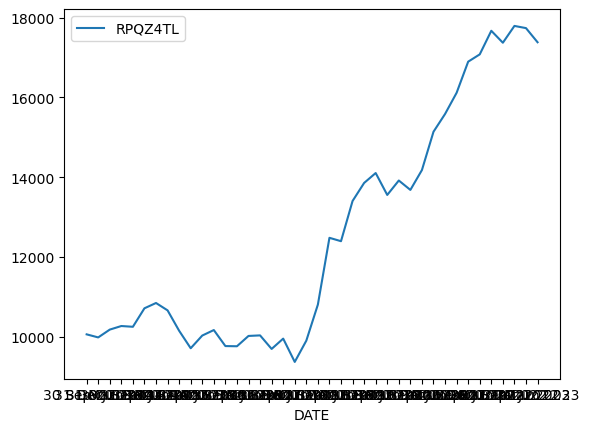

In [36]:
import seaborn as sns

sns.lineplot(df)